In [2]:
import os
import sys
sys.path.append(os.path.abspath(".."))

In [3]:
import torch
import numpy as np
import torchvision.transforms as transforms
import seaborn as sns
import ristretto.activations as ra
import ristretto.models as rm
import ristretto.utils as ru
import pandas as pd
import warnings
from functools import partial

with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)
    import ray
    from ray import tune
    from ray.tune import JupyterNotebookReporter
    from ray.tune.schedulers import ASHAScheduler
# from torch.utils.tensorboard import SummaryWriter

In [4]:
# set pytorch precision
torch.set_default_tensor_type(torch.FloatTensor)
torch.set_default_dtype(torch.bfloat16)

In [4]:
ray.init(runtime_env={"working_dir": ".."}, log_to_driver=False)
# ray.init(runtime_env={"working_dir": ".."})

2022-12-19 15:57:39,441	INFO worker.py:1528 -- Started a local Ray instance.
2022-12-19 15:57:40,498	INFO packaging.py:527 -- Creating a file package for local directory '..'.
2022-12-19 15:57:41,473	INFO packaging.py:354 -- Pushing file package 'gcs://_ray_pkg_e23c18e6705ba885.zip' (8.39MiB) to Ray cluster...
2022-12-19 15:57:41,748	INFO packaging.py:367 -- Successfully pushed file package 'gcs://_ray_pkg_e23c18e6705ba885.zip'.


Python version:,3.9.13
Ray version:,2.1.0


### Including ReLU6 subgradients as hyperparameters

In [5]:
config = {
    "batch_size": tune.choice([32, 64, 128]),
    "lr": tune.loguniform(1e-4, 1e-2),
    "alpha": tune.uniform(0, 1),
    "beta": tune.uniform(0, 1),
}

In [6]:
epochs = 6
scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
    max_t=epochs,
    grace_period=3,
    reduction_factor=2)
reporter = JupyterNotebookReporter(
    # parameter_columns=["l1", "l2", "lr", "batch_size"],
    metric_columns=["loss", "accuracy", "training_iteration"])

In [7]:
result_sub = tune.run(
    partial(ru.tune_train_mobilenet),
    resources_per_trial={"cpu": 8, "gpu": 1},
    config=config,
    num_samples=10,
    scheduler=scheduler,
    progress_reporter=reporter,
    fail_fast="raise"
)

C:\Users\tomma\AppData\Roaming\Python\Python39\site-packages\ray\tune\trainable\function_trainable.py:609: DeprecationWarning: `checkpoint_dir` in `func(config, checkpoint_dir)` is being deprecated. To save and load checkpoint in trainable functions, please use the `ray.air.session` API:

from ray.air import session

def train(config):
    # ...
    session.report({"metric": metric}, checkpoint=checkpoint)

For more information please see https://docs.ray.io/en/master/tune/api_docs/trainable.html

  warnings.warn(
C:\Users\tomma\AppData\Roaming\Python\Python39\site-packages\ray\tune\execution\trial_runner.py:363: UserWarning: fail_fast='raise' detected. Be careful when using this mode as resources (such as Ray processes, file descriptors, and temporary files) may not be cleaned up properly. To use a safer mode, use fail_fast=True.
  warnings.warn(


Trial name,accuracy,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,loss,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
tune_train_mobilenet_7d0da_00000,93.3167,2022-12-19_16-47-44,True,,680e9f1d5a344e8bb0ec496da73cc0ff,MSI-Tommy,6,0.246164,127.0.0.1,20724,True,2985.74,543.575,2985.74,1671464864,0,,6,7d0da_00000,0.00600076
tune_train_mobilenet_7d0da_00001,50.975,2022-12-19_17-13-03,True,,7d8ed563483544d7956514a659e8b28e,MSI-Tommy,3,1.21858,127.0.0.1,30600,True,1503.74,539.629,1503.74,1671466383,0,,3,7d0da_00001,0.0129955
tune_train_mobilenet_7d0da_00002,86.2417,2022-12-19_18-19-41,True,,cdbf49eb16974fefbc9df1c8da1bbd63,MSI-Tommy,6,0.490534,127.0.0.1,10508,True,3984.75,562.826,3984.75,1671470381,0,,6,7d0da_00002,0.00700068
tune_train_mobilenet_7d0da_00003,92.6333,2022-12-19_19-03-17,True,,3962e470cb97413bb84599bea11a3916,MSI-Tommy,6,0.274375,127.0.0.1,28292,True,2605.69,410.801,2605.69,1671472997,0,,6,7d0da_00003,0.0290053
tune_train_mobilenet_7d0da_00004,95.4417,2022-12-19_19-59-09,True,,4e2e4965074844d2a3bca10890914f7c,MSI-Tommy,6,0.151713,127.0.0.1,19212,True,3344.07,531.258,3344.07,1671476349,0,,6,7d0da_00004,0.00700235
tune_train_mobilenet_7d0da_00005,96.9167,2022-12-19_20-44-24,True,,6b70272a2b6e4c3ea839948621aa2243,MSI-Tommy,6,0.101213,127.0.0.1,31000,True,2702.93,453.034,2702.93,1671479064,0,,6,7d0da_00005,0.00700259
tune_train_mobilenet_7d0da_00006,92.3833,2022-12-19_21-26-28,True,,eb68475b67124b5da9fd9b0fe253db5f,MSI-Tommy,6,0.258748,127.0.0.1,1860,True,2512.51,395.812,2512.51,1671481588,0,,6,7d0da_00006,0.00607777
tune_train_mobilenet_7d0da_00007,95.725,2022-12-19_22-08-22,True,,6580f47207e2402ea4fe2a783b89a9cd,MSI-Tommy,6,0.145204,127.0.0.1,35424,True,2505.51,430.676,2505.51,1671484102,0,,6,7d0da_00007,0.00696278
tune_train_mobilenet_7d0da_00008,79.3417,2022-12-19_22-28-54,True,,848087a073dd43a7ac1bc26a99a74c11,MSI-Tommy,3,0.868642,127.0.0.1,12592,True,1222.11,406.745,1222.11,1671485334,0,,3,7d0da_00008,0.00600505
tune_train_mobilenet_7d0da_00009,47.1667,2022-12-19_22-47-12,True,,17fe4810706c466bab9cc27372c8ad95,MSI-Tommy,3,1.78117,127.0.0.1,30156,True,1089.51,347.119,1089.51,1671486432,0,,3,7d0da_00009,0.0060339


2022-12-19 22:47:12,964	INFO tune.py:777 -- Total run time: 24570.73 seconds (24570.51 seconds for the tuning loop).


In [8]:
result_sub.results_df.to_csv("results_with_subgradient.csv")

In [12]:
result_sub.results_df

,loss,accuracy,time_this_iter_s,should_checkpoint,done,timesteps_total,episodes_total,training_iteration,experiment_id,date,...,node_ip,time_since_restore,timesteps_since_restore,iterations_since_restore,warmup_time,experiment_tag,config/batch_size,config/lr,config/alpha,config/beta
trial_id,,,,,,,,,,,,,,,,,,,,,
7d0da_00000,0.246164,93.316667,543.575419,True,True,None,None,6,680e9f1d5a344e8bb0ec496da73cc0ff,2022-12-19_16-47-44,...,127.0.0.1,2985.736464,0,6,0.006001,"0_alpha=0.0317,batch_size=64,beta=0.0210,lr=0....",64,0.000715,0.031714,0.021016
7d0da_00001,1.218584,50.975000,539.628989,True,True,None,None,3,7d8ed563483544d7956514a659e8b28e,2022-12-19_17-13-03,...,127.0.0.1,1503.736701,0,3,0.012995,"1_alpha=0.5812,batch_size=128,beta=0.4738,lr=0...",128,0.000612,0.581190,0.473808
7d0da_00002,0.490534,86.241667,562.825582,True,True,None,None,6,cdbf49eb16974fefbc9df1c8da1bbd63,2022-12-19_18-19-41,...,127.0.0.1,3984.753614,0,6,0.007001,"2_alpha=0.3646,batch_size=32,beta=0.1239,lr=0....",32,0.000283,0.364603,0.123855
7d0da_00003,0.274375,92.633333,410.800784,True,True,None,None,6,3962e470cb97413bb84599bea11a3916,2022-12-19_19-03-17,...,127.0.0.1,2605.694029,0,6,0.029005,"3_alpha=0.6238,batch_size=64,beta=0.5538,lr=0....",64,0.000635,0.623757,0.553808
7d0da_00004,0.151713,95.441667,531.258432,True,True,None,None,6,4e2e4965074844d2a3bca10890914f7c,2022-12-19_19-59-09,...,127.0.0.1,3344.065195,0,6,0.007002,"4_alpha=0.0100,batch_size=32,beta=0.3054,lr=0....",32,0.003416,0.010036,0.305395
7d0da_00005,0.101213,96.916667,453.033938,True,True,None,None,6,6b70272a2b6e4c3ea839948621aa2243,2022-12-19_20-44-24,...,127.0.0.1,2702.931339,0,6,0.007003,"5_alpha=0.4964,batch_size=64,beta=0.4552,lr=0....",64,0.001702,0.496422,0.455249
7d0da_00006,0.258748,92.383333,395.811705,True,True,None,None,6,eb68475b67124b5da9fd9b0fe253db5f,2022-12-19_21-26-28,...,127.0.0.1,2512.510325,0,6,0.006078,"6_alpha=0.4566,batch_size=64,beta=0.6294,lr=0....",64,0.000734,0.456647,0.629418
7d0da_00007,0.145204,95.725000,430.676160,True,True,None,None,6,6580f47207e2402ea4fe2a783b89a9cd,2022-12-19_22-08-22,...,127.0.0.1,2505.509907,0,6,0.006963,"7_alpha=0.8498,batch_size=64,beta=0.6949,lr=0....",64,0.005442,0.849757,0.694936
7d0da_00008,0.868642,79.341667,406.744773,True,True,None,None,3,848087a073dd43a7ac1bc26a99a74c11,2022-12-19_22-28-54,...,127.0.0.1,1222.109127,0,3,0.006005,"8_alpha=0.6737,batch_size=64,beta=0.2470,lr=0....",64,0.000235,0.673719,0.246992


In [13]:
print(f"""Best loss: {result_sub.get_best_config(metric="loss", mode="min")}""")
print(f"""Best accuracy: {result_sub.get_best_config(metric="accuracy", mode="max")}""")

Best loss: {'batch_size': 64, 'lr': 0.0017023949730420136, 'alpha': 0.4964223539245872, 'beta': 0.45524949449837515}
Best accuracy: {'batch_size': 64, 'lr': 0.0017023949730420136, 'alpha': 0.4964223539245872, 'beta': 0.45524949449837515}


### With fixed ReLU6 subgradients

In [15]:
config = {
    "batch_size": tune.choice([32, 64, 128]),
    "lr": tune.loguniform(1e-4, 1e-2),
    "alpha": tune.choice([0]),
    "beta": tune.choice([0]),
}

In [16]:
epochs = 6
scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
    max_t=epochs,
    grace_period=3,
    reduction_factor=2)
reporter = JupyterNotebookReporter(
    # parameter_columns=["l1", "l2", "lr", "batch_size"],
    metric_columns=["loss", "accuracy", "training_iteration"])

In [17]:
result_no_sub = tune.run(
    partial(ru.tune_train_mobilenet),
    resources_per_trial={"cpu": 8, "gpu": 1},
    config=config,
    num_samples=10,
    scheduler=scheduler,
    progress_reporter=reporter
)

Trial name,accuracy,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,loss,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
tune_train_mobilenet_19eae_00000,90.0333,2022-12-20_00-05-49,True,,f4f173a07f884916aa72d20ee9efe32e,MSI-Tommy,6,0.40837,127.0.0.1,34624,True,4098,514.653,4098,1671491149,0,,6,19eae_00000,0.0805442
tune_train_mobilenet_19eae_00001,80.9333,2022-12-20_00-25-05,True,,d2a7115790854f55a6dda36841cef16c,MSI-Tommy,3,1.01471,127.0.0.1,26996,True,1146.42,396.786,1146.42,1671492305,0,,3,19eae_00001,0.0110009
tune_train_mobilenet_19eae_00002,96.475,2022-12-20_01-08-12,True,,7eefd807184240b4805d2309771a6555,MSI-Tommy,6,0.123575,127.0.0.1,4288,True,2576.24,456.624,2576.24,1671494892,0,,6,19eae_00002,0.0193861
tune_train_mobilenet_19eae_00003,97.3583,2022-12-20_01-51-54,True,,1fba622a91964979bfe8e41c58c02c5a,MSI-Tommy,6,0.0869832,127.0.0.1,34228,True,2612.77,426.686,2612.77,1671497514,0,,6,19eae_00003,0
tune_train_mobilenet_19eae_00004,93.9583,2022-12-20_02-35-15,True,,e8ca59b59922448b914e675c2ea1d5ac,MSI-Tommy,6,0.212998,127.0.0.1,21784,True,2592.5,435.714,2592.5,1671500115,0,,6,19eae_00004,0.00411391
tune_train_mobilenet_19eae_00005,73.7833,2022-12-20_02-54-14,True,,3128f230eb3b44f4b6352ac9c70d3ef7,MSI-Tommy,3,1.23928,127.0.0.1,33232,True,1129.62,373.32,1129.62,1671501254,0,,3,19eae_00005,0.00494957
tune_train_mobilenet_19eae_00006,92.125,2022-12-20_03-46-01,True,,4cf0826e743044658acc5e583a08b160,MSI-Tommy,6,0.26509,127.0.0.1,35196,True,3097.53,512.781,3097.53,1671504361,0,,6,19eae_00006,0.00700855
tune_train_mobilenet_19eae_00007,67.3583,2022-12-20_04-06-46,True,,188987bc6bc9406aa976b2c580eed4e0,MSI-Tommy,3,1.1158,127.0.0.1,36964,True,1235.93,413.325,1235.93,1671505606,0,,3,19eae_00007,0.00602078
tune_train_mobilenet_19eae_00008,93.0083,2022-12-20_10-40-27,True,,913b5bca0da147e1b90ef92cdac5d0ea,MSI-Tommy,6,0.263371,127.0.0.1,10948,True,23611.8,509.856,23611.8,1671529227,0,,6,19eae_00008,0.00599647
tune_train_mobilenet_19eae_00009,96.9833,2022-12-20_11-31-35,True,,c0ad3571b86f449d8c4a6ee019962750,MSI-Tommy,6,0.0999944,127.0.0.1,18728,True,3054.59,449.163,3054.59,1671532295,0,,6,19eae_00009,0.00700331


2022-12-20 11:31:35,744	INFO tune.py:777 -- Total run time: 45259.52 seconds (45259.36 seconds for the tuning loop).


In [18]:
result_no_sub.results_df.to_csv("results_without_subgradient.csv")

In [19]:
print(f"""Best loss: {result_no_sub.get_best_config(metric="loss", mode="min")}""")
print(f"""Best accuracy: {result_no_sub.get_best_config(metric="accuracy", mode="max")}""")

Best loss: {'batch_size': 64, 'lr': 0.003172197778201321, 'alpha': 0, 'beta': 0}
Best accuracy: {'batch_size': 64, 'lr': 0.003172197778201321, 'alpha': 0, 'beta': 0}


# Further train best models

In [5]:
result_sub_df = pd.read_csv("results_with_subgradient.csv")
result_no_sub_df = pd.read_csv("results_without_subgradient.csv")

In [6]:
# activate 
ra.ReLU6Function.print_when_zero = True

### Model 1 - with with subradients as hyperparameters

In [7]:
best = result_sub_df.iloc[result_sub_df["loss"].idxmin()]
alpha = best["config/alpha"]
beta = best["config/beta"]
model_sub = rm.mobilenet_v3_small(activation_fn=partial(ra.ReLU6, alpha, beta), seed=42).to("cuda")

In [8]:
from torchvision import transforms
from torch.utils.data import DataLoader, random_split

train_set, test_set = ru.default.DATASETS["MNIST"](transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
    ]))

ru.set_random_seed(42)

train_size = int(len(train_set) * 0.8)
train, val = random_split(
    train_set, [train_size, len(train_set) - train_size])

train_loader = DataLoader(
    train, batch_size=64, shuffle=True, num_workers=8)

val_loader = DataLoader(
    val, batch_size=64, shuffle=False, num_workers=8)

In [9]:
epochs = 10

In [10]:
import math
from ristretto.utils import train_loop, val_loop
import torch.nn.functional as F
from itertools import chain

optimizer = torch.optim.Adam(model_sub.parameters(), lr=0.001)
criterion = F.cross_entropy

train_metrics = []
val_metrics = []
for epoch in range(epochs):
    print(
        f"---------- Epoch {epoch+1:{math.ceil(math.log10(epochs+1))}d} ----------")
    train_metrics.append(train_loop(
        model_sub, optimizer, criterion, train_loader, verbose=False, dtype=torch.bfloat16))
    val_metrics.append(val_loop(
        model_sub, criterion, val_loader, dtype=torch.bfloat16))

sub_metrics = {
    "train": pd.DataFrame(chain.from_iterable(train_metrics)),
    "validation": pd.DataFrame(chain.from_iterable(val_metrics))
}

---------- Epoch  1 ----------
Found 1 item with input == 6
Found 2 items with input == 6
Found 1 item with input == 6
Found 1 item with input == 6
Found 2 items with input == 6
Found 1 item with input == 6
Found 1 item with input == 6
Found 4 items with input == 6
Found 1 item with input == 6
Found 1 item with input == 6
Found 1 item with input == 6
Found 1 item with input == 6
Found 1 item with input == 6
Found 1 item with input == 6
Found 1 item with input == 6
Found 1 item with input == 6
Found 1 item with input == 6
Found 2 items with input == 6
Found 1 item with input == 6
Found 1 item with input == 6
Found 1 item with input == 6
Found 1 item with input == 6
Found 1 item with input == 6
Found 1 item with input == 6
Found 1 item with input == 6
Found 1 item with input == 6
Found 1 item with input == 6
Found 1 item with input == 6
Found 1 item with input == 6
Found 1 item with input == 6
Found 1 item with input == 6
Found 2 items with input == 6
Found 1 item with input == 6
Found 1

### Model 2 - without subgradients as hyperparameters

In [15]:
model_no_sub = rm.mobilenet_v3_small(activation_fn=partial(ra.ReLU6, 0, 0), seed=42).to("cuda")

In [16]:
from torchvision import transforms
from torch.utils.data import DataLoader, random_split

train_set, test_set = ru.default.DATASETS["MNIST"](transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
    ]))

ru.set_random_seed(42)

train_size = int(len(train_set) * 0.8)
train, val = random_split(
    train_set, [train_size, len(train_set) - train_size])

train_loader = DataLoader(
    train, batch_size=64, shuffle=True, num_workers=8)

val_loader = DataLoader(
    val, batch_size=64, shuffle=False, num_workers=8)

In [17]:
epochs = 10

In [18]:
import math
from ristretto.utils import train_loop, val_loop
import torch.nn.functional as F
from itertools import chain

optimizer = torch.optim.Adam(model_no_sub.parameters(), lr=0.001)
criterion = F.cross_entropy

train_metrics = []
val_metrics = []
for epoch in range(epochs):
    print(
        f"---------- Epoch {epoch+1:{math.ceil(math.log10(epochs+1))}d} ----------")
    train_metrics.append(train_loop(
        model_no_sub, optimizer, criterion, train_loader, verbose=False, dtype=torch.bfloat16))
    val_metrics.append(val_loop(
        model_no_sub, criterion, val_loader, dtype=torch.bfloat16))

no_sub_metrics = {
    "train": pd.DataFrame(chain.from_iterable(train_metrics)),
    "validation": pd.DataFrame(chain.from_iterable(val_metrics))
}

---------- Epoch  1 ----------
Found 1 item with input == 6
Found 1 item with input == 6
Found 3 items with input == 6
Found 1 item with input == 6
Found 4 items with input == 6
Found 1 item with input == 6
Found 1 item with input == 6
Found 2 items with input == 6
Found 1 item with input == 6
Found 6 items with input == 6
Found 1 item with input == 6
Found 5 items with input == 6
Found 1 item with input == 6
Found 1 item with input == 6
Found 2 items with input == 6
Found 1 item with input == 6
Found 4 items with input == 6
Found 1 item with input == 6
Found 2 items with input == 6
Found 2 items with input == 6
Found 1 item with input == 6
Found 1 item with input == 6
Found 1 item with input == 6
Found 1 item with input == 6
Found 2 items with input == 6
Found 2 items with input == 6
Found 1 item with input == 6
Found 2 items with input == 6
Found 1 item with input == 6
Found 1 item with input == 6
Found 2 items with input == 6
Found 2 items with input == 6
Found 1 item with input == 

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

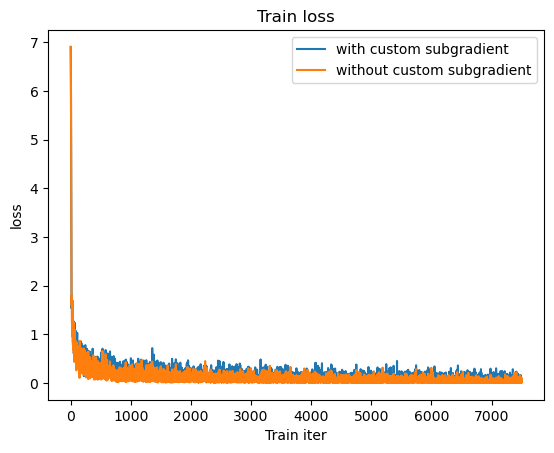

In [58]:
sns.lineplot(data=sub_metrics["train"]["loss"], label="with custom subgradient")
sns.lineplot(data=no_sub_metrics["train"]["loss"], label="without custom subgradient")
plt.xlabel("Train iter")
plt.title("Train loss");

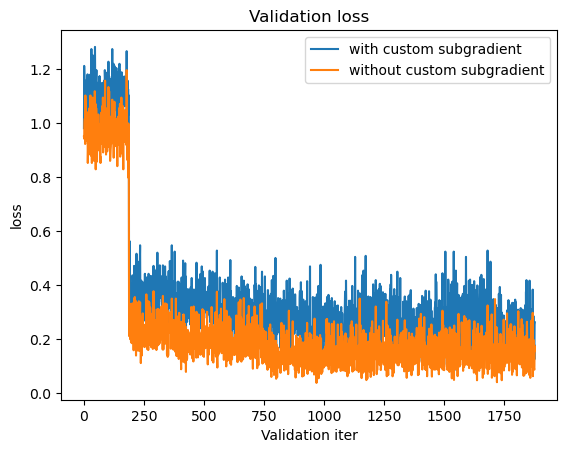

In [59]:
sns.lineplot(data=sub_metrics["validation"]["loss"], label="with custom subgradient")
sns.lineplot(data=no_sub_metrics["validation"]["loss"], label="without custom subgradient")
plt.xlabel("Validation iter")
plt.title("Validation loss");